## Task 2: Regional TOA Changes

### Preprocessing Data

In [1]:
#imports
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [3]:
gcs = gcsfs.GCSFileSystem(token='anon')

In [4]:
def load_zarr_dset(df):
  # get the path to a specific zarr store (the first one from the dataframe above)
  zstore = df.zstore.values[-1]

  # create a mutable-mapping-style interface to the store
  mapper = gcs.get_mapper(zstore)

  # open it using xarray and zarr
  ds = xr.open_zarr(mapper, consolidated=True)
  return ds

In [5]:
#time index for hist+ssp585
new_time_index_hist_ssp = pd.date_range('1850-01-01', '2099-12-31', freq = 'ME')
new_time_index_hist_ssp

DatetimeIndex(['1850-01-31', '1850-02-28', '1850-03-31', '1850-04-30',
               '1850-05-31', '1850-06-30', '1850-07-31', '1850-08-31',
               '1850-09-30', '1850-10-31',
               ...
               '2099-03-31', '2099-04-30', '2099-05-31', '2099-06-30',
               '2099-07-31', '2099-08-31', '2099-09-30', '2099-10-31',
               '2099-11-30', '2099-12-31'],
              dtype='datetime64[ns]', length=3000, freq='ME')

In [6]:
#regrid to common 1x1 grid
new_lats=np.arange(-87,88)
new_lons=np.arange(1,359)

In [7]:
#rlut
df_hist_toa_rlut = df.query(  "activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
df_ssp585_toa_rlut = df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
#rsut
df_hist_toa_rsut = df.query(  "activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
df_ssp585_toa_rsut = df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
#rsdt
df_hist_toa_rsdt = df.query(  "activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
df_ssp585_toa_rsdt = df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
#models
models_toa_hist_rlut  =set(df_hist_toa_rlut.source_id)
models_toa_hist_rsut  =set(df_hist_toa_rsut.source_id)
models_toa_hist_rsdt  =set(df_hist_toa_rsdt.source_id) # all models that have toa in the historical simulations
models_toa_ssp585_rlut=set(df_ssp585_toa_rlut.source_id) #all models that have toa in the ssp585 simulations
models_toa_ssp585_rsut=set(df_ssp585_toa_rsut.source_id)
models_toa_ssp585_rsdt=set(df_ssp585_toa_rsdt.source_id)

#intersection of all of the models that have all radiation types
source_set_toa_2 = set.intersection(models_toa_hist_rlut, models_toa_hist_rsut, models_toa_hist_rsdt, models_toa_ssp585_rlut, models_toa_ssp585_rsut, models_toa_ssp585_rsdt)
source_list_toa_2 = list(source_set_toa_2)
print(len(source_list_toa_2))

31


In [8]:
#remove models
model_list = ['E3SM-1-1',
               'TaiESM1',
               'CIESM',
              'KIOST-ESM',
               'INM-CM5-0',
               'FGOALS-f3-L',
               'CMCC-CM2-SR5',
               'EC-Earth3-Veg-LR',
               'FIO-ESM-2-0',
               'IITM-ESM',
               'NESM3']

In [9]:
for source in model_list:
    if source in source_list_toa_2:
        source_list_toa_2.remove(source)
print(len(source_list_toa_2))
print(source_list_toa_2)

20
['FGOALS-g3', 'MRI-ESM2-0', 'CanESM5', 'GFDL-CM4', 'MPI-ESM1-2-LR', 'EC-Earth3', 'NorESM2-LM', 'CESM2-WACCM', 'MIROC6', 'GFDL-ESM4', 'INM-CM4-8', 'BCC-CSM2-MR', 'AWI-CM-1-1-MR', 'MPI-ESM1-2-HR', 'IPSL-CM6A-LR', 'EC-Earth3-Veg', 'NorESM2-MM', 'CAMS-CSM1-0', 'KACE-1-0-G', 'ACCESS-CM2']


### 2.1 Analysis for One Model

In [24]:
#query data
#historical data
df_toa_hist_rlut = df.query(  "activity_id=='CMIP' & source_id == 'NorESM2-MM' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
df_toa_hist_rsut = df.query(  "activity_id=='CMIP' & source_id == 'NorESM2-MM' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
df_toa_hist_rsdt = df.query(  "activity_id=='CMIP' & source_id == 'NorESM2-MM' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
df_toacs_hist_rlutcs = df.query("activity_id=='CMIP' & source_id == 'NorESM2-MM' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
df_toacs_hist_rsutcs = df.query("activity_id=='CMIP' & source_id == 'NorESM2-MM' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
    
#load hist data as dataset
ds_toa_hist_rlut = load_zarr_dset(df_toa_hist_rlut)
ds_toa_hist_rsut = load_zarr_dset(df_toa_hist_rsut)
ds_toa_hist_rsdt = load_zarr_dset(df_toa_hist_rsdt)
ds_toacs_hist_rlutcs = load_zarr_dset(df_toacs_hist_rlutcs)
ds_toacs_hist_rsutcs = load_zarr_dset(df_toacs_hist_rsutcs)
    
#ssp585 data
df_toa_ssp585_rlut = df.query("activity_id=='ScenarioMIP' & source_id == 'NorESM2-MM' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
df_toa_ssp585_rsut = df.query("activity_id=='ScenarioMIP' & source_id == 'NorESM2-MM' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
df_toa_ssp585_rsdt = df.query("activity_id=='ScenarioMIP' & source_id == 'NorESM2-MM' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
df_toacs_ssp585_rlutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'NorESM2-MM' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
df_toacs_ssp585_rsutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'NorESM2-MM' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
#load ssp data as dataset
ds_toa_ssp585_rlut = load_zarr_dset(df_toa_ssp585_rlut)
ds_toa_ssp585_rsut = load_zarr_dset(df_toa_ssp585_rsut)
ds_toa_ssp585_rsdt = load_zarr_dset(df_toa_ssp585_rsdt)
ds_toacs_ssp585_rlutcs = load_zarr_dset(df_toacs_ssp585_rlutcs)
ds_toacs_ssp585_rsutcs = load_zarr_dset(df_toacs_ssp585_rsutcs)

#toa variable
ds_hist_toa = ds_toa_hist_rsdt.rsdt - ds_toa_hist_rsut.rsut - ds_toa_hist_rlut.rlut
ds_ssp585_toa = ds_toa_ssp585_rsdt.rsdt - ds_toa_ssp585_rsut.rsut - ds_toa_ssp585_rlut.rlut
#compute diff between avg over years 2089-2099 and 1989-1999
ds_hist_toa = ds_hist_toa.sel(time=slice('1989','1999'))
ds_ssp585_toa = ds_ssp585_toa.sel(time=slice('2089','2099'))
ds_toa = xr.concat([ds_hist_toa, ds_ssp585_toa], dim = 'time', coords = 'all', compat = 'override')

#toacs and final cre variable
ds_hist_toacs = ds_toa_hist_rsdt.rsdt - ds_toacs_hist_rlutcs.rlutcs - ds_toacs_hist_rsutcs.rsutcs
ds_ssp585_toacs = ds_toa_ssp585_rsdt.rsdt - ds_toacs_ssp585_rlutcs.rlutcs - ds_toacs_ssp585_rsutcs.rsutcs
ds_hist_toacs = ds_hist_toacs.sel(time=slice('1989','1999'))
ds_ssp585_toacs = ds_ssp585_toacs.sel(time=slice('2089','2099'))
ds_hist_cre = ds_hist_toa - ds_hist_toacs
ds_ssp585_cre = ds_ssp585_toa - ds_ssp585_toacs
ds_cre = xr.concat([ds_hist_cre, ds_ssp585_cre], dim = 'time', coords = 'all', compat = 'override')
    
#combine toa and cre data-arrays
ds_toa_cre_merged = xr.Dataset({'toa': ds_toa, 'cre': ds_cre})

#difference among toa 
dtoa = ds_ssp585_toa.mean('time')-ds_hist_toa.mean('time')
dtoa
#difference among cre
dcre = ds_ssp585_cre.mean('time')-ds_hist_cre.mean('time')  
dcre
#combined difference (toa+cre) ds
dtoa_cre = xr.Dataset({'dtoa': dtoa, 'dcre':dcre})
dtoa_cre

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    dtoa     (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    dcre     (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>

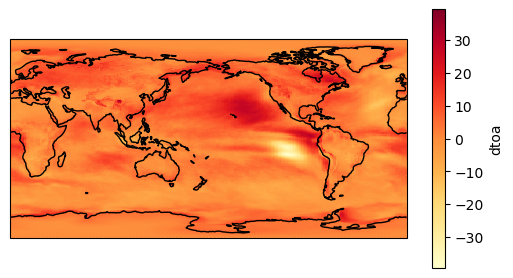

In [25]:
#plot of TOA
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
dtoa_cre.dtoa.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), cbar_kwargs = {"shrink": 0.7})

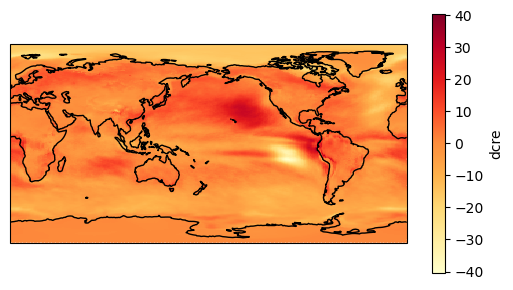

In [26]:
#plot of CRE
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
dtoa_cre.dcre.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), cbar_kwargs = {"shrink": 0.7})

### 2.2 Multiple Models

In [27]:
gcm_list = ['MIROC6', 'GFDL-ESM4', 'AWI-CM-1-1-MR', 'MPI-ESM1-2-HR', 'CanESM5']

In [30]:
#query data
ds_gcm_list = list()
for source in gcm_list:
    #historical data
    df_toa_hist_rlut = df.query(  "activity_id=='CMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
    df_toa_hist_rsut = df.query(  "activity_id=='CMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
    df_toa_hist_rsdt = df.query(  "activity_id=='CMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
    df_toacs_hist_rlutcs = df.query("activity_id=='CMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
    df_toacs_hist_rsutcs = df.query("activity_id=='CMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
    
    #load hist data as dataset
    ds_toa_hist_rlut = load_zarr_dset(df_toa_hist_rlut)
    ds_toa_hist_rsut = load_zarr_dset(df_toa_hist_rsut)
    ds_toa_hist_rsdt = load_zarr_dset(df_toa_hist_rsdt)
    ds_toacs_hist_rlutcs = load_zarr_dset(df_toacs_hist_rlutcs)
    ds_toacs_hist_rsutcs = load_zarr_dset(df_toacs_hist_rsutcs)
    
    #ssp585 data
    df_toa_ssp585_rlut = df.query("activity_id=='ScenarioMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
    df_toa_ssp585_rsut = df.query("activity_id=='ScenarioMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
    df_toa_ssp585_rsdt = df.query("activity_id=='ScenarioMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
    df_toacs_ssp585_rlutcs = df.query("activity_id=='ScenarioMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
    df_toacs_ssp585_rsutcs = df.query("activity_id=='ScenarioMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
    #load ssp data as dataset
    ds_toa_ssp585_rlut = load_zarr_dset(df_toa_ssp585_rlut)
    ds_toa_ssp585_rsut = load_zarr_dset(df_toa_ssp585_rsut)
    ds_toa_ssp585_rsdt = load_zarr_dset(df_toa_ssp585_rsdt)
    ds_toacs_ssp585_rlutcs = load_zarr_dset(df_toacs_ssp585_rlutcs)
    ds_toacs_ssp585_rsutcs = load_zarr_dset(df_toacs_ssp585_rsutcs)

    #toa variable
    ds_hist_toa = ds_toa_hist_rsdt.rsdt - ds_toa_hist_rsut.rsut - ds_toa_hist_rlut.rlut
    ds_ssp585_toa = ds_toa_ssp585_rsdt.rsdt - ds_toa_ssp585_rsut.rsut - ds_toa_ssp585_rlut.rlut
    #compute diff between avg over years 2089-2099 and 1989-1999
    ds_hist_toa = ds_hist_toa.sel(time=slice('1989','1999'))
    ds_ssp585_toa = ds_ssp585_toa.sel(time=slice('2089','2099'))
    ds_toa = xr.concat([ds_hist_toa, ds_ssp585_toa], dim = 'time', coords = 'all', compat = 'override')

    #toacs and final cre variable
    ds_hist_toacs = ds_toa_hist_rsdt.rsdt - ds_toacs_hist_rlutcs.rlutcs - ds_toacs_hist_rsutcs.rsutcs
    ds_ssp585_toacs = ds_toa_ssp585_rsdt.rsdt - ds_toacs_ssp585_rlutcs.rlutcs - ds_toacs_ssp585_rsutcs.rsutcs
    ds_hist_toacs = ds_hist_toacs.sel(time=slice('1989','1999'))
    ds_ssp585_toacs = ds_ssp585_toacs.sel(time=slice('2089','2099'))
    ds_hist_cre = ds_hist_toa - ds_hist_toacs
    ds_ssp585_cre = ds_ssp585_toa - ds_ssp585_toacs
    ds_cre = xr.concat([ds_hist_cre, ds_ssp585_cre], dim = 'time', coords = 'all', compat = 'override')
    
    #combine toa and cre data-arrays
    ds_toa_cre_merged = xr.Dataset({'toa': ds_toa, 'cre': ds_cre})

    #difference among toa 
    dtoa = ds_ssp585_toa.mean('time')-ds_hist_toa.mean('time')
    #difference among cre
    dcre = ds_ssp585_cre.mean('time')-ds_hist_cre.mean('time')
    #interp
    dtoa = dtoa.interp(lat = new_lats, lon = new_lons)
    dcre = dcre.interp(lat=new_lats, lon=new_lons)
    #combined difference (toa+cre) ds
    dtoa_cre = xr.Dataset({'toa': dtoa, 'cre':dcre})
    dtoa_cre = dtoa_cre.assign_coords(model=source)
    ds_gcm_list.append(dtoa_cre)
ds_gcm_models = xr.concat(ds_gcm_list, dim = 'model', coords = 'minimal', compat = 'override')
ds_gcm_models

<xarray.Dataset>
Dimensions:  (lat: 175, lon: 358, model: 5)
Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
  * model    (model) <U13 'MIROC6' 'GFDL-ESM4' ... 'MPI-ESM1-2-HR' 'CanESM5'
Data variables:
    toa      (model, lat, lon) float32 dask.array<chunksize=(1, 175, 358), meta=np.ndarray>
    cre      (model, lat, lon) float32 dask.array<chunksize=(1, 175, 358), meta=np.ndarray>

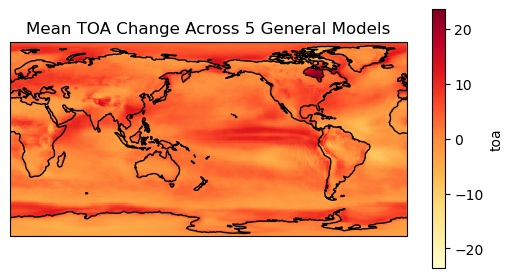

In [31]:
#TOA plot
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
ds_gcm_models_mean = ds_gcm_models.toa.mean(dim='model') #took mean across models to eliminate one dimension and mash all model data tg -> 2D now
ds_gcm_models_mean.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), cbar_kwargs = {"shrink": 0.7})
plt.title('Mean TOA Change Across 5 General Models')
plt.show()

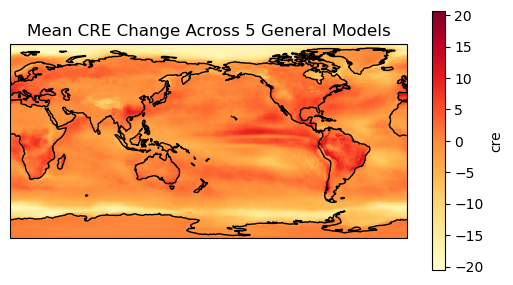

In [33]:
#CRE plot
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
ds_gcm_models_mean = ds_gcm_models.cre.mean(dim='model') #took mean across models to eliminate one dimension and mash all model data tg -> 2D now
ds_gcm_models_mean.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), cbar_kwargs = {"shrink": 0.7})
plt.title('Mean CRE Change Across 5 General Models')
plt.show()

### Adding 8 More Models

In [20]:
ds_list_8_models = list()
#query data
#historical data
df_toa_hist_rlut = df.query(  "activity_id=='CMIP' & source_id == 'CNRM-CM6-1-HR' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toa_hist_rsut = df.query(  "activity_id=='CMIP' & source_id == 'CNRM-CM6-1-HR' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toa_hist_rsdt = df.query(  "activity_id=='CMIP' & source_id == 'CNRM-CM6-1-HR' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toacs_hist_rlutcs = df.query("activity_id=='CMIP' & source_id == 'CNRM-CM6-1-HR' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toacs_hist_rsutcs = df.query("activity_id=='CMIP' & source_id == 'CNRM-CM6-1-HR' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
    
#load hist data as dataset
ds_toa_hist_rlut = load_zarr_dset(df_toa_hist_rlut)
ds_toa_hist_rsut = load_zarr_dset(df_toa_hist_rsut)
ds_toa_hist_rsdt = load_zarr_dset(df_toa_hist_rsdt)
ds_toacs_hist_rlutcs = load_zarr_dset(df_toacs_hist_rlutcs)
ds_toacs_hist_rsutcs = load_zarr_dset(df_toacs_hist_rsutcs)
    
#ssp585 data
df_toa_ssp585_rlut = df.query("activity_id=='ScenarioMIP' & source_id == 'CNRM-CM6-1-HR' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toa_ssp585_rsut = df.query("activity_id=='ScenarioMIP' & source_id == 'CNRM-CM6-1-HR' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toa_ssp585_rsdt = df.query("activity_id=='ScenarioMIP' & source_id == 'CNRM-CM6-1-HR' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toacs_ssp585_rlutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'CNRM-CM6-1-HR' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toacs_ssp585_rsutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'CNRM-CM6-1-HR' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")

#load ssp data as dataset
ds_toa_ssp585_rlut = load_zarr_dset(df_toa_ssp585_rlut)
ds_toa_ssp585_rsut = load_zarr_dset(df_toa_ssp585_rsut)
ds_toa_ssp585_rsdt = load_zarr_dset(df_toa_ssp585_rsdt)
ds_toacs_ssp585_rlutcs = load_zarr_dset(df_toacs_ssp585_rlutcs)
ds_toacs_ssp585_rsutcs = load_zarr_dset(df_toacs_ssp585_rsutcs)

#toa variable
ds_hist_toa = ds_toa_hist_rsdt.rsdt - ds_toa_hist_rsut.rsut - ds_toa_hist_rlut.rlut
ds_ssp585_toa = ds_toa_ssp585_rsdt.rsdt - ds_toa_ssp585_rsut.rsut - ds_toa_ssp585_rlut.rlut
#compute diff between avg over years 2089-2099 and 1989-1999
ds_hist_toa = ds_hist_toa.sel(time=slice('1989','1999'))
ds_ssp585_toa = ds_ssp585_toa.sel(time=slice('2089','2099'))
ds_toa = xr.concat([ds_hist_toa, ds_ssp585_toa], dim = 'time', coords = 'all', compat = 'override')

#toacs and final cre variable
ds_hist_toacs = ds_toa_hist_rsdt.rsdt - ds_toacs_hist_rlutcs.rlutcs - ds_toacs_hist_rsutcs.rsutcs
ds_ssp585_toacs = ds_toa_ssp585_rsdt.rsdt - ds_toacs_ssp585_rlutcs.rlutcs - ds_toacs_ssp585_rsutcs.rsutcs
ds_hist_toacs = ds_hist_toacs.sel(time=slice('1989','1999'))
ds_ssp585_toacs = ds_ssp585_toacs.sel(time=slice('2089','2099'))
ds_hist_cre = ds_hist_toa - ds_hist_toacs
ds_ssp585_cre = ds_ssp585_toa - ds_ssp585_toacs
ds_cre = xr.concat([ds_hist_cre, ds_ssp585_cre], dim = 'time', coords = 'all', compat = 'override')
    
#combine toa and cre data-arrays
ds_toa_cre_merged = xr.Dataset({'toa': ds_toa, 'cre': ds_cre})

#difference among toa 
dtoa = ds_ssp585_toa.mean('time')-ds_hist_toa.mean('time')
#difference among cre
dcre = ds_ssp585_cre.mean('time')-ds_hist_cre.mean('time')
#interp
dtoa = dtoa.interp(lat = new_lats, lon = new_lons)
dcre = dcre.interp(lat=new_lats, lon=new_lons)
#combined difference (toa+cre) ds
dtoa_cre = xr.Dataset({'toa': dtoa, 'cre':dcre})
dtoa_cre = dtoa_cre.assign_coords(model=ds_toa_hist_rlut.source_id)
ds_list_8_models.append(dtoa_cre)
dtoa_cre.coords

Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
    model    <U13 'CNRM-CM6-1-HR'

In [21]:
#query data
#historical data
df_toa_hist_rlut = df.query(  "activity_id=='CMIP' & source_id == 'MIROC-ES2L' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toa_hist_rsut = df.query(  "activity_id=='CMIP' & source_id == 'MIROC-ES2L' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toa_hist_rsdt = df.query(  "activity_id=='CMIP' & source_id == 'MIROC-ES2L' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toacs_hist_rlutcs = df.query("activity_id=='CMIP' & source_id == 'MIROC-ES2L' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toacs_hist_rsutcs = df.query("activity_id=='CMIP' & source_id == 'MIROC-ES2L' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
    
#load hist data as dataset
ds_toa_hist_rlut = load_zarr_dset(df_toa_hist_rlut)
ds_toa_hist_rsut = load_zarr_dset(df_toa_hist_rsut)
ds_toa_hist_rsdt = load_zarr_dset(df_toa_hist_rsdt)
ds_toacs_hist_rlutcs = load_zarr_dset(df_toacs_hist_rlutcs)
ds_toacs_hist_rsutcs = load_zarr_dset(df_toacs_hist_rsutcs)
    
#ssp585 data
df_toa_ssp585_rlut = df.query("activity_id=='ScenarioMIP' & source_id == 'MIROC-ES2L' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toa_ssp585_rsut = df.query("activity_id=='ScenarioMIP' & source_id == 'MIROC-ES2L' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toa_ssp585_rsdt = df.query("activity_id=='ScenarioMIP' & source_id == 'MIROC-ES2L' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toacs_ssp585_rlutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'MIROC-ES2L' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toacs_ssp585_rsutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'MIROC-ES2L' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")

#load ssp data as dataset
ds_toa_ssp585_rlut = load_zarr_dset(df_toa_ssp585_rlut)
ds_toa_ssp585_rsut = load_zarr_dset(df_toa_ssp585_rsut)
ds_toa_ssp585_rsdt = load_zarr_dset(df_toa_ssp585_rsdt)
ds_toacs_ssp585_rlutcs = load_zarr_dset(df_toacs_ssp585_rlutcs)
ds_toacs_ssp585_rsutcs = load_zarr_dset(df_toacs_ssp585_rsutcs)

#toa variable
ds_hist_toa = ds_toa_hist_rsdt.rsdt - ds_toa_hist_rsut.rsut - ds_toa_hist_rlut.rlut
ds_ssp585_toa = ds_toa_ssp585_rsdt.rsdt - ds_toa_ssp585_rsut.rsut - ds_toa_ssp585_rlut.rlut
#compute diff between avg over years 2089-2099 and 1989-1999
ds_hist_toa = ds_hist_toa.sel(time=slice('1989','1999'))
ds_ssp585_toa = ds_ssp585_toa.sel(time=slice('2089','2099'))
ds_toa = xr.concat([ds_hist_toa, ds_ssp585_toa], dim = 'time', coords = 'all', compat = 'override')

#toacs and final cre variable
ds_hist_toacs = ds_toa_hist_rsdt.rsdt - ds_toacs_hist_rlutcs.rlutcs - ds_toacs_hist_rsutcs.rsutcs
ds_ssp585_toacs = ds_toa_ssp585_rsdt.rsdt - ds_toacs_ssp585_rlutcs.rlutcs - ds_toacs_ssp585_rsutcs.rsutcs
ds_hist_toacs = ds_hist_toacs.sel(time=slice('1989','1999'))
ds_ssp585_toacs = ds_ssp585_toacs.sel(time=slice('2089','2099'))
ds_hist_cre = ds_hist_toa - ds_hist_toacs
ds_ssp585_cre = ds_ssp585_toa - ds_ssp585_toacs
ds_cre = xr.concat([ds_hist_cre, ds_ssp585_cre], dim = 'time', coords = 'all', compat = 'override')
    
#combine toa and cre data-arrays
ds_toa_cre_merged = xr.Dataset({'toa': ds_toa, 'cre': ds_cre})

#difference among toa 
dtoa = ds_ssp585_toa.mean('time')-ds_hist_toa.mean('time')
#difference among cre
dcre = ds_ssp585_cre.mean('time')-ds_hist_cre.mean('time')
#interp
dtoa = dtoa.interp(lat = new_lats, lon = new_lons)
dcre = dcre.interp(lat=new_lats, lon=new_lons)
#combined difference (toa+cre) ds
dtoa_cre = xr.Dataset({'toa': dtoa, 'cre':dcre})
dtoa_cre = dtoa_cre.assign_coords(model=ds_toa_hist_rlut.source_id)
ds_list_8_models.append(dtoa_cre)
dtoa_cre.coords

Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
    model    <U10 'MIROC-ES2L'

In [22]:
#query data
#historical data
df_toa_hist_rlut = df.query(  "activity_id=='CMIP' & source_id == 'CNRM-ESM2-1' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toa_hist_rsut = df.query(  "activity_id=='CMIP' & source_id == 'CNRM-ESM2-1' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toa_hist_rsdt = df.query(  "activity_id=='CMIP' & source_id == 'CNRM-ESM2-1' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toacs_hist_rlutcs = df.query("activity_id=='CMIP' & source_id == 'CNRM-ESM2-1' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toacs_hist_rsutcs = df.query("activity_id=='CMIP' & source_id == 'CNRM-ESM2-1' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
    
#load hist data as dataset
ds_toa_hist_rlut = load_zarr_dset(df_toa_hist_rlut)
ds_toa_hist_rsut = load_zarr_dset(df_toa_hist_rsut)
ds_toa_hist_rsdt = load_zarr_dset(df_toa_hist_rsdt)
ds_toacs_hist_rlutcs = load_zarr_dset(df_toacs_hist_rlutcs)
ds_toacs_hist_rsutcs = load_zarr_dset(df_toacs_hist_rsutcs)
    
#ssp585 data
df_toa_ssp585_rlut = df.query("activity_id=='ScenarioMIP' & source_id == 'CNRM-ESM2-1' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toa_ssp585_rsut = df.query("activity_id=='ScenarioMIP' & source_id == 'CNRM-ESM2-1' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toa_ssp585_rsdt = df.query("activity_id=='ScenarioMIP' & source_id == 'CNRM-ESM2-1' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toacs_ssp585_rlutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'CNRM-ESM2-1' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toacs_ssp585_rsutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'CNRM-ESM2-1' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")

#load ssp data as dataset
ds_toa_ssp585_rlut = load_zarr_dset(df_toa_ssp585_rlut)
ds_toa_ssp585_rsut = load_zarr_dset(df_toa_ssp585_rsut)
ds_toa_ssp585_rsdt = load_zarr_dset(df_toa_ssp585_rsdt)
ds_toacs_ssp585_rlutcs = load_zarr_dset(df_toacs_ssp585_rlutcs)
ds_toacs_ssp585_rsutcs = load_zarr_dset(df_toacs_ssp585_rsutcs)

#toa variable
ds_hist_toa = ds_toa_hist_rsdt.rsdt - ds_toa_hist_rsut.rsut - ds_toa_hist_rlut.rlut
ds_ssp585_toa = ds_toa_ssp585_rsdt.rsdt - ds_toa_ssp585_rsut.rsut - ds_toa_ssp585_rlut.rlut
#compute diff between avg over years 2089-2099 and 1989-1999
ds_hist_toa = ds_hist_toa.sel(time=slice('1989','1999'))
ds_ssp585_toa = ds_ssp585_toa.sel(time=slice('2089','2099'))
ds_toa = xr.concat([ds_hist_toa, ds_ssp585_toa], dim = 'time', coords = 'all', compat = 'override')

#toacs and final cre variable
ds_hist_toacs = ds_toa_hist_rsdt.rsdt - ds_toacs_hist_rlutcs.rlutcs - ds_toacs_hist_rsutcs.rsutcs
ds_ssp585_toacs = ds_toa_ssp585_rsdt.rsdt - ds_toacs_ssp585_rlutcs.rlutcs - ds_toacs_ssp585_rsutcs.rsutcs
ds_hist_toacs = ds_hist_toacs.sel(time=slice('1989','1999'))
ds_ssp585_toacs = ds_ssp585_toacs.sel(time=slice('2089','2099'))
ds_hist_cre = ds_hist_toa - ds_hist_toacs
ds_ssp585_cre = ds_ssp585_toa - ds_ssp585_toacs
ds_cre = xr.concat([ds_hist_cre, ds_ssp585_cre], dim = 'time', coords = 'all', compat = 'override')
    
#combine toa and cre data-arrays
ds_toa_cre_merged = xr.Dataset({'toa': ds_toa, 'cre': ds_cre})

#difference among toa 
dtoa = ds_ssp585_toa.mean('time')-ds_hist_toa.mean('time')
#difference among cre
dcre = ds_ssp585_cre.mean('time')-ds_hist_cre.mean('time')
#interp
dtoa = dtoa.interp(lat = new_lats, lon = new_lons)
dcre = dcre.interp(lat=new_lats, lon=new_lons)
#combined difference (toa+cre) ds
dtoa_cre = xr.Dataset({'toa': dtoa, 'cre':dcre})
dtoa_cre = dtoa_cre.assign_coords(model=ds_toa_hist_rlut.source_id)
ds_list_8_models.append(dtoa_cre)
dtoa_cre.coords

Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
    model    <U11 'CNRM-ESM2-1'

In [23]:
#query data
#historical data
df_toa_hist_rlut = df.query(  "activity_id=='CMIP' & source_id ==  'UKESM1-0-LL' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toa_hist_rsut = df.query(  "activity_id=='CMIP' & source_id ==  'UKESM1-0-LL' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toa_hist_rsdt = df.query(  "activity_id=='CMIP' & source_id ==  'UKESM1-0-LL' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toacs_hist_rlutcs = df.query("activity_id=='CMIP' & source_id ==  'UKESM1-0-LL' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toacs_hist_rsutcs = df.query("activity_id=='CMIP' & source_id ==  'UKESM1-0-LL' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
    
#load hist data as dataset
ds_toa_hist_rlut = load_zarr_dset(df_toa_hist_rlut)
ds_toa_hist_rsut = load_zarr_dset(df_toa_hist_rsut)
ds_toa_hist_rsdt = load_zarr_dset(df_toa_hist_rsdt)
ds_toacs_hist_rlutcs = load_zarr_dset(df_toacs_hist_rlutcs)
ds_toacs_hist_rsutcs = load_zarr_dset(df_toacs_hist_rsutcs)
    
#ssp585 data
df_toa_ssp585_rlut = df.query("activity_id=='ScenarioMIP' & source_id ==  'UKESM1-0-LL' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toa_ssp585_rsut = df.query("activity_id=='ScenarioMIP' & source_id ==  'UKESM1-0-LL' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toa_ssp585_rsdt = df.query("activity_id=='ScenarioMIP' & source_id ==  'UKESM1-0-LL' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toacs_ssp585_rlutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'UKESM1-0-LL' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toacs_ssp585_rsutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'UKESM1-0-LL' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")

#load ssp data as dataset
ds_toa_ssp585_rlut = load_zarr_dset(df_toa_ssp585_rlut)
ds_toa_ssp585_rsut = load_zarr_dset(df_toa_ssp585_rsut)
ds_toa_ssp585_rsdt = load_zarr_dset(df_toa_ssp585_rsdt)
ds_toacs_ssp585_rlutcs = load_zarr_dset(df_toacs_ssp585_rlutcs)
ds_toacs_ssp585_rsutcs = load_zarr_dset(df_toacs_ssp585_rsutcs)

#toa variable
ds_hist_toa = ds_toa_hist_rsdt.rsdt - ds_toa_hist_rsut.rsut - ds_toa_hist_rlut.rlut
ds_ssp585_toa = ds_toa_ssp585_rsdt.rsdt - ds_toa_ssp585_rsut.rsut - ds_toa_ssp585_rlut.rlut
#compute diff between avg over years 2089-2099 and 1989-1999
ds_hist_toa = ds_hist_toa.sel(time=slice('1989','1999'))
ds_ssp585_toa = ds_ssp585_toa.sel(time=slice('2089','2099'))
ds_toa = xr.concat([ds_hist_toa, ds_ssp585_toa], dim = 'time', coords = 'all', compat = 'override')

#toacs and final cre variable
ds_hist_toacs = ds_toa_hist_rsdt.rsdt - ds_toacs_hist_rlutcs.rlutcs - ds_toacs_hist_rsutcs.rsutcs
ds_ssp585_toacs = ds_toa_ssp585_rsdt.rsdt - ds_toacs_ssp585_rlutcs.rlutcs - ds_toacs_ssp585_rsutcs.rsutcs
ds_hist_toacs = ds_hist_toacs.sel(time=slice('1989','1999'))
ds_ssp585_toacs = ds_ssp585_toacs.sel(time=slice('2089','2099'))
ds_hist_cre = ds_hist_toa - ds_hist_toacs
ds_ssp585_cre = ds_ssp585_toa - ds_ssp585_toacs
ds_cre = xr.concat([ds_hist_cre, ds_ssp585_cre], dim = 'time', coords = 'all', compat = 'override')
    
#combine toa and cre data-arrays
ds_toa_cre_merged = xr.Dataset({'toa': ds_toa, 'cre': ds_cre})

#difference among toa 
dtoa = ds_ssp585_toa.mean('time')-ds_hist_toa.mean('time')
#difference among cre
dcre = ds_ssp585_cre.mean('time')-ds_hist_cre.mean('time')
#interp
dtoa = dtoa.interp(lat = new_lats, lon = new_lons)
dcre = dcre.interp(lat=new_lats, lon=new_lons)
#combined difference (toa+cre) ds
dtoa_cre = xr.Dataset({'toa': dtoa, 'cre':dcre})
dtoa_cre = dtoa_cre.assign_coords(model=ds_toa_hist_rlut.source_id)
ds_list_8_models.append(dtoa_cre)
dtoa_cre.coords

Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
    model    <U11 'UKESM1-0-LL'

In [24]:
#query data
#historical data
df_toa_hist_rlut = df.query(  "activity_id=='CMIP' & source_id ==  'CNRM-CM6-1' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toa_hist_rsut = df.query(  "activity_id=='CMIP' & source_id ==  'CNRM-CM6-1' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toa_hist_rsdt = df.query(  "activity_id=='CMIP' & source_id ==  'CNRM-CM6-1' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toacs_hist_rlutcs = df.query("activity_id=='CMIP' & source_id ==  'CNRM-CM6-1' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
df_toacs_hist_rsutcs = df.query("activity_id=='CMIP' & source_id ==  'CNRM-CM6-1' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='historical' & member_id == 'r1i1p1f2'")
    
#load hist data as dataset
ds_toa_hist_rlut = load_zarr_dset(df_toa_hist_rlut)
ds_toa_hist_rsut = load_zarr_dset(df_toa_hist_rsut)
ds_toa_hist_rsdt = load_zarr_dset(df_toa_hist_rsdt)
ds_toacs_hist_rlutcs = load_zarr_dset(df_toacs_hist_rlutcs)
ds_toacs_hist_rsutcs = load_zarr_dset(df_toacs_hist_rsutcs)
    
#ssp585 data
df_toa_ssp585_rlut = df.query("activity_id=='ScenarioMIP' & source_id ==  'CNRM-CM6-1' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toa_ssp585_rsut = df.query("activity_id=='ScenarioMIP' & source_id ==  'CNRM-CM6-1' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toa_ssp585_rsdt = df.query("activity_id=='ScenarioMIP' & source_id ==  'CNRM-CM6-1' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toacs_ssp585_rlutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'CNRM-CM6-1' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")
df_toacs_ssp585_rsutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'CNRM-CM6-1' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f2'")

#load ssp data as dataset
ds_toa_ssp585_rlut = load_zarr_dset(df_toa_ssp585_rlut)
ds_toa_ssp585_rsut = load_zarr_dset(df_toa_ssp585_rsut)
ds_toa_ssp585_rsdt = load_zarr_dset(df_toa_ssp585_rsdt)
ds_toacs_ssp585_rlutcs = load_zarr_dset(df_toacs_ssp585_rlutcs)
ds_toacs_ssp585_rsutcs = load_zarr_dset(df_toacs_ssp585_rsutcs)

#toa variable
ds_hist_toa = ds_toa_hist_rsdt.rsdt - ds_toa_hist_rsut.rsut - ds_toa_hist_rlut.rlut
ds_ssp585_toa = ds_toa_ssp585_rsdt.rsdt - ds_toa_ssp585_rsut.rsut - ds_toa_ssp585_rlut.rlut
#compute diff between avg over years 2089-2099 and 1989-1999
ds_hist_toa = ds_hist_toa.sel(time=slice('1989','1999'))
ds_ssp585_toa = ds_ssp585_toa.sel(time=slice('2089','2099'))
ds_toa = xr.concat([ds_hist_toa, ds_ssp585_toa], dim = 'time', coords = 'all', compat = 'override')

#toacs and final cre variable
ds_hist_toacs = ds_toa_hist_rsdt.rsdt - ds_toacs_hist_rlutcs.rlutcs - ds_toacs_hist_rsutcs.rsutcs
ds_ssp585_toacs = ds_toa_ssp585_rsdt.rsdt - ds_toacs_ssp585_rlutcs.rlutcs - ds_toacs_ssp585_rsutcs.rsutcs
ds_hist_toacs = ds_hist_toacs.sel(time=slice('1989','1999'))
ds_ssp585_toacs = ds_ssp585_toacs.sel(time=slice('2089','2099'))
ds_hist_cre = ds_hist_toa - ds_hist_toacs
ds_ssp585_cre = ds_ssp585_toa - ds_ssp585_toacs
ds_cre = xr.concat([ds_hist_cre, ds_ssp585_cre], dim = 'time', coords = 'all', compat = 'override')
    
#combine toa and cre data-arrays
ds_toa_cre_merged = xr.Dataset({'toa': ds_toa, 'cre': ds_cre})

#difference among toa 
dtoa = ds_ssp585_toa.mean('time')-ds_hist_toa.mean('time')
#difference among cre
dcre = ds_ssp585_cre.mean('time')-ds_hist_cre.mean('time')
#interp
dtoa = dtoa.interp(lat = new_lats, lon = new_lons)
dcre = dcre.interp(lat=new_lats, lon=new_lons)
#combined difference (toa+cre) ds
dtoa_cre = xr.Dataset({'toa': dtoa, 'cre':dcre})
dtoa_cre = dtoa_cre.assign_coords(model=ds_toa_hist_rlut.source_id)
ds_list_8_models.append(dtoa_cre)
dtoa_cre.coords

Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
    model    <U10 'CNRM-CM6-1'

In [25]:
#query data
#historical data
df_toa_hist_rlut = df.query(  "activity_id=='CMIP' & source_id ==  'HadGEM3-GC31-LL' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='historical' & member_id == 'r1i1p1f3'")
df_toa_hist_rsut = df.query(  "activity_id=='CMIP' & source_id ==  'HadGEM3-GC31-LL' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='historical' & member_id == 'r1i1p1f3'")
df_toa_hist_rsdt = df.query(  "activity_id=='CMIP' & source_id ==  'HadGEM3-GC31-LL' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='historical' & member_id == 'r1i1p1f3'")
df_toacs_hist_rlutcs = df.query("activity_id=='CMIP' & source_id ==  'HadGEM3-GC31-LL' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='historical' & member_id == 'r1i1p1f3'")
df_toacs_hist_rsutcs = df.query("activity_id=='CMIP' & source_id ==  'HadGEM3-GC31-LL' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='historical' & member_id == 'r1i1p1f3'")
    
#load hist data as dataset
ds_toa_hist_rlut = load_zarr_dset(df_toa_hist_rlut)
ds_toa_hist_rsut = load_zarr_dset(df_toa_hist_rsut)
ds_toa_hist_rsdt = load_zarr_dset(df_toa_hist_rsdt)
ds_toacs_hist_rlutcs = load_zarr_dset(df_toacs_hist_rlutcs)
ds_toacs_hist_rsutcs = load_zarr_dset(df_toacs_hist_rsutcs)
    
#ssp585 data
df_toa_ssp585_rlut = df.query("activity_id=='ScenarioMIP' & source_id ==  'HadGEM3-GC31-LL' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='ssp585' & member_id == 'r1i1p1f3'")
df_toa_ssp585_rsut = df.query("activity_id=='ScenarioMIP' & source_id ==  'HadGEM3-GC31-LL' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='ssp585' & member_id == 'r1i1p1f3'")
df_toa_ssp585_rsdt = df.query("activity_id=='ScenarioMIP' & source_id ==  'HadGEM3-GC31-LL' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='ssp585' & member_id == 'r1i1p1f3'")
df_toacs_ssp585_rlutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'HadGEM3-GC31-LL' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f3'")
df_toacs_ssp585_rsutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'HadGEM3-GC31-LL' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f3'")

#load ssp data as dataset
ds_toa_ssp585_rlut = load_zarr_dset(df_toa_ssp585_rlut)
ds_toa_ssp585_rsut = load_zarr_dset(df_toa_ssp585_rsut)
ds_toa_ssp585_rsdt = load_zarr_dset(df_toa_ssp585_rsdt)
ds_toacs_ssp585_rlutcs = load_zarr_dset(df_toacs_ssp585_rlutcs)
ds_toacs_ssp585_rsutcs = load_zarr_dset(df_toacs_ssp585_rsutcs)

#toa variable
ds_hist_toa = ds_toa_hist_rsdt.rsdt - ds_toa_hist_rsut.rsut - ds_toa_hist_rlut.rlut
ds_ssp585_toa = ds_toa_ssp585_rsdt.rsdt - ds_toa_ssp585_rsut.rsut - ds_toa_ssp585_rlut.rlut
#compute diff between avg over years 2089-2099 and 1989-1999
ds_hist_toa = ds_hist_toa.sel(time=slice('1989','1999'))
ds_ssp585_toa = ds_ssp585_toa.sel(time=slice('2089','2099'))
ds_toa = xr.concat([ds_hist_toa, ds_ssp585_toa], dim = 'time', coords = 'all', compat = 'override')

#toacs and final cre variable
ds_hist_toacs = ds_toa_hist_rsdt.rsdt - ds_toacs_hist_rlutcs.rlutcs - ds_toacs_hist_rsutcs.rsutcs
ds_ssp585_toacs = ds_toa_ssp585_rsdt.rsdt - ds_toacs_ssp585_rlutcs.rlutcs - ds_toacs_ssp585_rsutcs.rsutcs
ds_hist_toacs = ds_hist_toacs.sel(time=slice('1989','1999'))
ds_ssp585_toacs = ds_ssp585_toacs.sel(time=slice('2089','2099'))
ds_hist_cre = ds_hist_toa - ds_hist_toacs
ds_ssp585_cre = ds_ssp585_toa - ds_ssp585_toacs
ds_cre = xr.concat([ds_hist_cre, ds_ssp585_cre], dim = 'time', coords = 'all', compat = 'override')
    
#combine toa and cre data-arrays
ds_toa_cre_merged = xr.Dataset({'toa': ds_toa, 'cre': ds_cre})

#difference among toa 
dtoa = ds_ssp585_toa.mean('time')-ds_hist_toa.mean('time')
#difference among cre
dcre = ds_ssp585_cre.mean('time')-ds_hist_cre.mean('time')
#interp
dtoa = dtoa.interp(lat = new_lats, lon = new_lons)
dcre = dcre.interp(lat=new_lats, lon=new_lons)
#combined difference (toa+cre) ds
dtoa_cre = xr.Dataset({'toa': dtoa, 'cre':dcre})
dtoa_cre = dtoa_cre.assign_coords(model=ds_toa_hist_rlut.source_id)
ds_list_8_models.append(dtoa_cre)
dtoa_cre.coords

Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
    model    <U15 'HadGEM3-GC31-LL'

In [26]:
#query data
#historical data
df_toa_hist_rlut = df.query(  "activity_id=='CMIP' & source_id ==  'CanESM5-CanOE' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='historical' & member_id == 'r1i1p2f1'")
df_toa_hist_rsut = df.query(  "activity_id=='CMIP' & source_id ==  'CanESM5-CanOE' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='historical' & member_id == 'r1i1p2f1'")
df_toa_hist_rsdt = df.query(  "activity_id=='CMIP' & source_id ==  'CanESM5-CanOE' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='historical' & member_id == 'r1i1p2f1'")
df_toacs_hist_rlutcs = df.query("activity_id=='CMIP' & source_id ==  'CanESM5-CanOE' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='historical' & member_id == 'r1i1p2f1'")
df_toacs_hist_rsutcs = df.query("activity_id=='CMIP' & source_id ==  'CanESM5-CanOE' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='historical' & member_id == 'r1i1p2f1'")
    
#load hist data as dataset
ds_toa_hist_rlut = load_zarr_dset(df_toa_hist_rlut)
ds_toa_hist_rsut = load_zarr_dset(df_toa_hist_rsut)
ds_toa_hist_rsdt = load_zarr_dset(df_toa_hist_rsdt)
ds_toacs_hist_rlutcs = load_zarr_dset(df_toacs_hist_rlutcs)
ds_toacs_hist_rsutcs = load_zarr_dset(df_toacs_hist_rsutcs)
    
#ssp585 data
df_toa_ssp585_rlut = df.query("activity_id=='ScenarioMIP' & source_id ==  'CanESM5-CanOE' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='ssp585' & member_id == 'r1i1p2f1'")
df_toa_ssp585_rsut = df.query("activity_id=='ScenarioMIP' & source_id ==  'CanESM5-CanOE' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='ssp585' & member_id == 'r1i1p2f1'")
df_toa_ssp585_rsdt = df.query("activity_id=='ScenarioMIP' & source_id ==  'CanESM5-CanOE' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='ssp585' & member_id == 'r1i1p2f1'")
df_toacs_ssp585_rlutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'CanESM5-CanOE' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='ssp585' & member_id == 'r1i1p2f1'")
df_toacs_ssp585_rsutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'CanESM5-CanOE' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='ssp585' & member_id == 'r1i1p2f1'")

#load ssp data as dataset
ds_toa_ssp585_rlut = load_zarr_dset(df_toa_ssp585_rlut)
ds_toa_ssp585_rsut = load_zarr_dset(df_toa_ssp585_rsut)
ds_toa_ssp585_rsdt = load_zarr_dset(df_toa_ssp585_rsdt)
ds_toacs_ssp585_rlutcs = load_zarr_dset(df_toacs_ssp585_rlutcs)
ds_toacs_ssp585_rsutcs = load_zarr_dset(df_toacs_ssp585_rsutcs)

#toa variable
ds_hist_toa = ds_toa_hist_rsdt.rsdt - ds_toa_hist_rsut.rsut - ds_toa_hist_rlut.rlut
ds_ssp585_toa = ds_toa_ssp585_rsdt.rsdt - ds_toa_ssp585_rsut.rsut - ds_toa_ssp585_rlut.rlut
#compute diff between avg over years 2089-2099 and 1989-1999
ds_hist_toa = ds_hist_toa.sel(time=slice('1989','1999'))
ds_ssp585_toa = ds_ssp585_toa.sel(time=slice('2089','2099'))
ds_toa = xr.concat([ds_hist_toa, ds_ssp585_toa], dim = 'time', coords = 'all', compat = 'override')

#toacs and final cre variable
ds_hist_toacs = ds_toa_hist_rsdt.rsdt - ds_toacs_hist_rlutcs.rlutcs - ds_toacs_hist_rsutcs.rsutcs
ds_ssp585_toacs = ds_toa_ssp585_rsdt.rsdt - ds_toacs_ssp585_rlutcs.rlutcs - ds_toacs_ssp585_rsutcs.rsutcs
ds_hist_toacs = ds_hist_toacs.sel(time=slice('1989','1999'))
ds_ssp585_toacs = ds_ssp585_toacs.sel(time=slice('2089','2099'))
ds_hist_cre = ds_hist_toa - ds_hist_toacs
ds_ssp585_cre = ds_ssp585_toa - ds_ssp585_toacs
ds_cre = xr.concat([ds_hist_cre, ds_ssp585_cre], dim = 'time', coords = 'all', compat = 'override')
    
#combine toa and cre data-arrays
ds_toa_cre_merged = xr.Dataset({'toa': ds_toa, 'cre': ds_cre})

#difference among toa 
dtoa = ds_ssp585_toa.mean('time')-ds_hist_toa.mean('time')
#difference among cre
dcre = ds_ssp585_cre.mean('time')-ds_hist_cre.mean('time')
#interp
dtoa = dtoa.interp(lat = new_lats, lon = new_lons)
dcre = dcre.interp(lat=new_lats, lon=new_lons)
#combined difference (toa+cre) ds
dtoa_cre = xr.Dataset({'toa': dtoa, 'cre':dcre})
dtoa_cre = dtoa_cre.assign_coords(model=ds_toa_hist_rlut.source_id)
ds_list_8_models.append(dtoa_cre)
dtoa_cre.coords

Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
    model    <U13 'CanESM5-CanOE'

In [27]:
#query data
#historical data
df_toa_hist_rlut = df.query(  "activity_id=='CMIP' & source_id ==  'CESM2' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='historical' & member_id == 'r10i1p1f1'")
df_toa_hist_rsut = df.query(  "activity_id=='CMIP' & source_id ==  'CESM2' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='historical' & member_id == 'r10i1p1f1'")
df_toa_hist_rsdt = df.query(  "activity_id=='CMIP' & source_id ==  'CESM2' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='historical' & member_id == 'r10i1p1f1'")
df_toacs_hist_rlutcs = df.query("activity_id=='CMIP' & source_id ==  'CESM2' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='historical' & member_id == 'r10i1p1f1'")
df_toacs_hist_rsutcs = df.query("activity_id=='CMIP' & source_id ==  'CESM2' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='historical' & member_id == 'r10i1p1f1'")
    
#load hist data as dataset
ds_toa_hist_rlut = load_zarr_dset(df_toa_hist_rlut)
ds_toa_hist_rsut = load_zarr_dset(df_toa_hist_rsut)
ds_toa_hist_rsdt = load_zarr_dset(df_toa_hist_rsdt)
ds_toacs_hist_rlutcs = load_zarr_dset(df_toacs_hist_rlutcs)
ds_toacs_hist_rsutcs = load_zarr_dset(df_toacs_hist_rsutcs)
    
#ssp585 data
df_toa_ssp585_rlut = df.query("activity_id=='ScenarioMIP' & source_id ==  'CESM2' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='ssp585' & member_id == 'r10i1p1f1'")
df_toa_ssp585_rsut = df.query("activity_id=='ScenarioMIP' & source_id ==  'CESM2' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='ssp585' & member_id == 'r10i1p1f1'")
df_toa_ssp585_rsdt = df.query("activity_id=='ScenarioMIP' & source_id ==  'CESM2' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='ssp585' & member_id == 'r10i1p1f1'")
df_toacs_ssp585_rlutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'CESM2' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='ssp585' & member_id == 'r10i1p1f1'")
df_toacs_ssp585_rsutcs = df.query("activity_id=='ScenarioMIP' & source_id == 'CESM2' & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='ssp585' & member_id == 'r10i1p1f1'")

#load ssp data as dataset
ds_toa_ssp585_rlut = load_zarr_dset(df_toa_ssp585_rlut)
ds_toa_ssp585_rsut = load_zarr_dset(df_toa_ssp585_rsut)
ds_toa_ssp585_rsdt = load_zarr_dset(df_toa_ssp585_rsdt)
ds_toacs_ssp585_rlutcs = load_zarr_dset(df_toacs_ssp585_rlutcs)
ds_toacs_ssp585_rsutcs = load_zarr_dset(df_toacs_ssp585_rsutcs)

#toa variable
ds_hist_toa = ds_toa_hist_rsdt.rsdt - ds_toa_hist_rsut.rsut - ds_toa_hist_rlut.rlut
ds_ssp585_toa = ds_toa_ssp585_rsdt.rsdt - ds_toa_ssp585_rsut.rsut - ds_toa_ssp585_rlut.rlut
#compute diff between avg over years 2089-2099 and 1989-1999
ds_hist_toa = ds_hist_toa.sel(time=slice('1989','1999'))
ds_ssp585_toa = ds_ssp585_toa.sel(time=slice('2089','2099'))
ds_toa = xr.concat([ds_hist_toa, ds_ssp585_toa], dim = 'time', coords = 'all', compat = 'override')

#toacs and final cre variable
ds_hist_toacs = ds_toa_hist_rsdt.rsdt - ds_toacs_hist_rlutcs.rlutcs - ds_toacs_hist_rsutcs.rsutcs
ds_ssp585_toacs = ds_toa_ssp585_rsdt.rsdt - ds_toacs_ssp585_rlutcs.rlutcs - ds_toacs_ssp585_rsutcs.rsutcs
ds_hist_toacs = ds_hist_toacs.sel(time=slice('1989','1999'))
ds_ssp585_toacs = ds_ssp585_toacs.sel(time=slice('2089','2099'))
ds_hist_cre = ds_hist_toa - ds_hist_toacs
ds_ssp585_cre = ds_ssp585_toa - ds_ssp585_toacs
ds_cre = xr.concat([ds_hist_cre, ds_ssp585_cre], dim = 'time', coords = 'all', compat = 'override')
    
#combine toa and cre data-arrays
ds_toa_cre_merged = xr.Dataset({'toa': ds_toa, 'cre': ds_cre})

#difference among toa 
dtoa = ds_ssp585_toa.mean('time')-ds_hist_toa.mean('time')
#difference among cre
dcre = ds_ssp585_cre.mean('time')-ds_hist_cre.mean('time')
#interp
dtoa = dtoa.interp(lat = new_lats, lon = new_lons)
dcre = dcre.interp(lat=new_lats, lon=new_lons)
#combined difference (toa+cre) ds
dtoa_cre = xr.Dataset({'toa': dtoa, 'cre':dcre})
dtoa_cre = dtoa_cre.assign_coords(model=ds_toa_hist_rlut.source_id)
ds_list_8_models.append(dtoa_cre)
dtoa_cre.coords

Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
    model    <U5 'CESM2'

In [28]:
ds_8_models = xr.concat(ds_list_8_models, dim = 'model', coords = 'minimal', compat = 'override')
ds_8_models

<xarray.Dataset>
Dimensions:  (lat: 175, lon: 358, model: 8)
Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
  * model    (model) <U15 'CNRM-CM6-1-HR' 'MIROC-ES2L' ... 'CESM2'
Data variables:
    toa      (model, lat, lon) float32 dask.array<chunksize=(1, 175, 358), meta=np.ndarray>
    cre      (model, lat, lon) float32 dask.array<chunksize=(1, 175, 358), meta=np.ndarray>

In [29]:
#adding in the r1i1p1f1 models
#query data
ds_list = list()
for source in source_list_toa_2:
    #historical data
    df_toa_hist_rlut = df.query(  "activity_id=='CMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
    df_toa_hist_rsut = df.query(  "activity_id=='CMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
    df_toa_hist_rsdt = df.query(  "activity_id=='CMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
    df_toacs_hist_rlutcs = df.query("activity_id=='CMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
    df_toacs_hist_rsutcs = df.query("activity_id=='CMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
    
    #load hist data as dataset
    ds_toa_hist_rlut = load_zarr_dset(df_toa_hist_rlut)
    ds_toa_hist_rsut = load_zarr_dset(df_toa_hist_rsut)
    ds_toa_hist_rsdt = load_zarr_dset(df_toa_hist_rsdt)
    ds_toacs_hist_rlutcs = load_zarr_dset(df_toacs_hist_rlutcs)
    ds_toacs_hist_rsutcs = load_zarr_dset(df_toacs_hist_rsutcs)
    
    #ssp585 data
    df_toa_ssp585_rlut = df.query("activity_id=='ScenarioMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
    df_toa_ssp585_rsut = df.query("activity_id=='ScenarioMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
    df_toa_ssp585_rsdt = df.query("activity_id=='ScenarioMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
    df_toacs_ssp585_rlutcs = df.query("activity_id=='ScenarioMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
    df_toacs_ssp585_rsutcs = df.query("activity_id=='ScenarioMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'rsutcs' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
    #load ssp data as dataset
    ds_toa_ssp585_rlut = load_zarr_dset(df_toa_ssp585_rlut)
    ds_toa_ssp585_rsut = load_zarr_dset(df_toa_ssp585_rsut)
    ds_toa_ssp585_rsdt = load_zarr_dset(df_toa_ssp585_rsdt)
    ds_toacs_ssp585_rlutcs = load_zarr_dset(df_toacs_ssp585_rlutcs)
    ds_toacs_ssp585_rsutcs = load_zarr_dset(df_toacs_ssp585_rsutcs)

    #toa variable
    ds_hist_toa = ds_toa_hist_rsdt.rsdt - ds_toa_hist_rsut.rsut - ds_toa_hist_rlut.rlut
    ds_ssp585_toa = ds_toa_ssp585_rsdt.rsdt - ds_toa_ssp585_rsut.rsut - ds_toa_ssp585_rlut.rlut
    #compute diff between avg over years 2089-2099 and 1989-1999
    ds_hist_toa = ds_hist_toa.sel(time=slice('1989','1999'))
    ds_ssp585_toa = ds_ssp585_toa.sel(time=slice('2089','2099'))
    ds_toa = xr.concat([ds_hist_toa, ds_ssp585_toa], dim = 'time', coords = 'all', compat = 'override')

    #toacs and final cre variable
    ds_hist_toacs = ds_toa_hist_rsdt.rsdt - ds_toacs_hist_rlutcs.rlutcs - ds_toacs_hist_rsutcs.rsutcs
    ds_ssp585_toacs = ds_toa_ssp585_rsdt.rsdt - ds_toacs_ssp585_rlutcs.rlutcs - ds_toacs_ssp585_rsutcs.rsutcs
    ds_hist_toacs = ds_hist_toacs.sel(time=slice('1989','1999'))
    ds_ssp585_toacs = ds_ssp585_toacs.sel(time=slice('2089','2099'))
    ds_hist_cre = ds_hist_toa - ds_hist_toacs
    ds_ssp585_cre = ds_ssp585_toa - ds_ssp585_toacs
    ds_cre = xr.concat([ds_hist_cre, ds_ssp585_cre], dim = 'time', coords = 'all', compat = 'override')
    
    #combine toa and cre data-arrays
    ds_toa_cre_merged = xr.Dataset({'toa': ds_toa, 'cre': ds_cre})

    #difference among toa 
    dtoa = ds_ssp585_toa.mean('time')-ds_hist_toa.mean('time')
    #difference among cre
    dcre = ds_ssp585_cre.mean('time')-ds_hist_cre.mean('time')
    #interp
    dtoa = dtoa.interp(lat = new_lats, lon = new_lons)
    dcre = dcre.interp(lat=new_lats, lon=new_lons)
    #combined difference (toa+cre) ds
    dtoa_cre = xr.Dataset({'toa': dtoa, 'cre':dcre})
    dtoa_cre = dtoa_cre.assign_coords(model=source)
    ds_list.append(dtoa_cre)
ds_toa_models = xr.concat(ds_list, dim = 'model', coords = 'minimal', compat = 'override')
ds_toa_models

C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\core\indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


TypeError: '<' not supported between instances of 'Timestamp' and 'str'

In [ ]:
#could it be that i don't have some models that don't go to 2089? why does it work for the first time select?